# Enzyme Module Figures

In [1]:
from os import path

import escher

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import sympy as sym

import mass
from mass import MassConfiguration, Simulation
from mass.io import json
from mass.util import strip_time
from mass.visualization import plot_time_profile, plot_phase_portrait

mass_config = MassConfiguration()
mass_config.decimal_precision = 12

escher.rc['never_ask_before_quit'] = True
mpl.rcsetup.defaultParams["font.family"] = "arial"
print("MASSpy version: " + mass.__version__)

MASSpy version: 0.1.1


In [2]:
model = json.load_json_model(
    path.abspath(path.join("data", "models", "JSON", "Glycolysis_Hb.json")))

model_w_PYK = json.load_json_model(
    path.abspath(path.join("data", "models", "JSON", "Glycolysis_Hb_PYK.json")))

r_scale_preset="GaBuRd",
m_scale_preset="WhYlRd"

# Function to save a figure
def save_figure(filename):
    plt.gca().get_figure()
    filepath = path.abspath(path.join("data", "figures", filename))
    plt.savefig(fname=filepath)

## Network Views of Steady State
### Load model without PYK EnzymeModule

In [3]:
sim_glyc_hb = Simulation(model, verbose=True)
conc_sol_ss, flux_sol_ss = sim_glyc_hb.find_steady_state(
    model, strategy="simulate", update_values=True,
    tfinal=1e5, decimal_precision=True);

builder = escher.Builder(
    model=model,
    map_json=path.abspath(path.join("data", "maps", "RBC.glycolysis.map.json")),
    reaction_data=dict(flux_sol_ss),
    metabolite_data=dict(conc_sol_ss),
    reaction_styles=["color", "text"],
    metabolite_styles=["color", "text"],
    reaction_scale_preset=r_scale_preset,
    metabolite_scale_preset=m_scale_preset,
)


Successfully loaded MassModel 'Glycolysis_Hb' into RoadRunner.


# Load model with PYK EnzymeModule

In [4]:
sim_glyc_hb_PYK = Simulation(model_w_PYK, verbose=True)
conc_sol_ss, flux_sol_ss = sim_glyc_hb_PYK.find_steady_state(
    model_w_PYK, strategy="simulate", update_values=True,
    tfinal=1e5, decimal_precision=True);

builder = escher.Builder(
    model=model_w_PYK,
    map_json=path.join("data", "maps", "RBC.glycolysis_PYK.map.json"),
    reaction_data=dict(flux_sol_ss),
    metabolite_data=dict(conc_sol_ss),
    reaction_styles=["color", "text"],
    metabolite_styles=["color", "text"],
    reaction_scale_preset=r_scale_preset,
    metabolite_scale_preset=m_scale_preset,
)
builder

Successfully loaded MassModel 'Glycolysis_Hb_PYK' into RoadRunner.


Builder(metabolite_data={'glc__D_c': 1.240819178407, 'g6p_c': 0.060218525965, 'f6p_c': 0.024563595492, 'fdp_c'…

## Network Views of Perturbation: ATP Utilization Increase by 50%
### Model without PYK EnzymeModule

In [5]:
t0, tf = (0, 1e4)
conc_sol, flux_sol = sim_glyc_hb.simulate(
    sim_glyc_hb.reference_model, time=(t0, tf), 
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    decimal_precision=True)

builder = escher.Builder(
    model=model,
    map_json=path.abspath(path.join("data", "maps", "RBC.glycolysis.map.json")),
    reaction_data={r: sol[-1] for r, sol in flux_sol.items()},
    metabolite_data={m: sol[-1] for m, sol in conc_sol.items()},
    reaction_styles=["color", "text"],
    metabolite_styles=["color", "text"],
    reaction_scale_preset=r_scale_preset,
    metabolite_scale_preset=m_scale_preset,
)
builder.save_html(path.abspath(path.join("data", "figures", "RBC.glycolysis.map.perturbed.html")))
builder

Builder(metabolite_data={'glc__D_c': 1.852597174233, 'g6p_c': 0.089763043425, 'f6p_c': 0.03667684765, 'fdp_c':…

### Model with PYK EnzymeModule

In [6]:
t0, tf = (0, 1e4)
conc_sol, flux_sol = sim_glyc_hb_PYK.simulate(
    sim_glyc_hb_PYK.reference_model, time=(t0, tf), 
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    decimal_precision=True)

builder = escher.Builder(
    model=model_w_PYK,
    map_json=path.abspath(path.join("data", "maps", "RBC.glycolysis_PYK.map.json")),
    reaction_data={r: sol[-1] for r, sol in flux_sol.items()},
    metabolite_data={m: sol[-1] for m, sol in conc_sol.items()},
    reaction_styles=["color", "text"],
    metabolite_styles=["color", "text"],
    reaction_scale_preset=r_scale_preset,
    metabolite_scale_preset=m_scale_preset,
)
builder.save_html(path.abspath(path.join("data", "figures", "RBC.glycolysis_PYK.map.perturbed.html")))
builder

Builder(metabolite_data={'glc__D_c': 1.817015159589, 'g6p_c': 0.088034275942, 'f6p_c': 0.035968052983, 'fdp_c'…

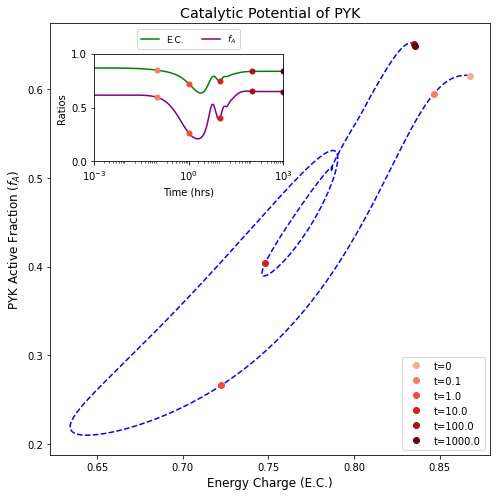

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

ax_inset = ax.inset_axes([0.1, 0.68, 0.43, 0.25])

PYK = model_w_PYK.enzyme_modules.PYK

# Define helper functions to make aggregate solutions
def make_energy_charge_solution(conc_sol):
    conc_sol.make_aggregate_solution(
        aggregate_id="energy_charge",
        equation="(atp_c + 0.5 * adp_c) / (atp_c + adp_c + amp_c)",
        variables=["atp_c", "adp_c", "amp_c"], update=True)

def make_active_fraction_solution(conc_sol):
    active = PYK.enzyme_module_forms_categorized.get_by_id(
        PYK.id + "_Active")
    conc_sol.make_aggregate_solution(
        aggregate_id="active_fraction",
        equation="({0}) / ({1})".format(
            " + ".join([e.id for e in active.members]),
             str(strip_time(PYK.enzyme_concentration_total_equation))),
        variables=PYK.enzyme_module_forms, update=True)
    
make_energy_charge_solution(conc_sol)
make_active_fraction_solution(conc_sol)

time_points = [t0, 1e-1, 1e0, 1e1, 1e2, 1e3]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

# Make phase portrait
plot_phase_portrait(
    conc_sol, x="energy_charge", y="active_fraction",
    ax=ax, legend=None,
    xlabel=("Energy Charge (E.C.)", {"size": "large"}),
    ylabel=("PYK Active Fraction ($f_{A}$)", {"size": "large"}),
    title=("Catalytic Potential of PYK", {"size": "x-large"}),
    linestyle="--", color="blue",
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="lower right")

plot_time_profile(
    conc_sol, observable=["energy_charge", "active_fraction"],
    ax=ax_inset,
    plot_function="semilogx",
    color=["green", "purple"], linestyle=["-"],
    xlabel="Time (hrs)", ylabel="Ratios", 
    xlim=(1e-3, 1e3), legend_ncol=1,
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_markersize=5)

handles, labels = ax_inset.get_legend_handles_labels()
ax_inset.legend(handles[:2], ["E.C.", "$f_{A}$"], loc="lower center",
                bbox_to_anchor=(0.5, 1), ncol=2,
                prop={'size': 9})
ax_inset.set_xticks([1e-3, 1, 1e3])
ax_inset.set_yticks([0, 0.5, 1])

fig.tight_layout()
save_figure("MASSpy-Pub-Fig2_PanelB.pdf")

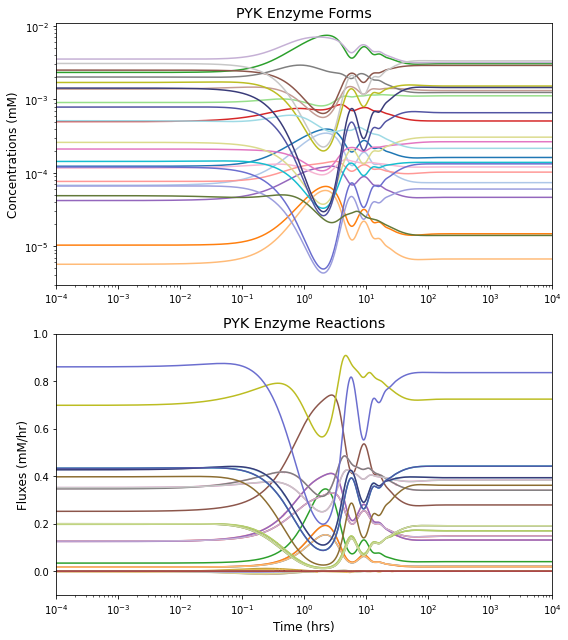

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 9))

plot_time_profile(
    conc_sol, observable=PYK.enzyme_module_forms,
    ax=ax1, # legend="right outside",
    plot_function="loglog", xlim=(1e-4, tf),
    ylabel=("Concentrations (mM)", {"size": "large"}),
    title=("PYK Enzyme Forms", {"size": "x-large"}))

plot_time_profile(
    flux_sol, observable=PYK.enzyme_module_reactions,
    ax=ax2, # legend="right outside",
    plot_function="semilogx", xlim=(1e-4, tf), ylim=(-1e-1, 1e0),
    xlabel=("Time (hrs)", {"size": "large",}),
    ylabel=("Fluxes (mM/hr)", {"size": "large"}),
    title=("PYK Enzyme Reactions", {"size": "x-large"}))

fig.tight_layout()
save_figure("MASSpy-Pub-Fig2_PanelC.pdf")